# Transit route type classification using gtfs2nx and graph neural networks

Use graph convolution neural network to classify graph nodes into bus, metro, tram, etc. stops.


In [99]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import torch_geometric.transforms as T

from gtfs2nx import utils
import gtfs2nx as gx

## Data: Create NetworkX graph

Select city of interest for which to download a GTFS feed and illustrate the potential of using GNN to classify route types.

Please note: Berlin GTFS data have the highest quality, yet due to the city size, creating a NetworkX graph of the transport network takes longer (7 min instead of 1:30 min for Toulouse and Leipzig).

In [110]:
# !wget -O gtfs-leipzig-example.zip https://opendata.leipzig.de/dataset/8803f612-2ce1-4643-82d1-213434889200/resource/b38955c4-431c-4e8b-a4ef-9964a3a2c95d/download/gtfsmdvlvb.zip
# !wget -O gtfs-toulouse-example.zip https://data.toulouse-metropole.fr/api/v2/catalog/datasets/tisseo-gtfs/files/fc1dda89077cf37e4f7521760e0ef4e9
!wget -O gtfs-berlin-example.zip http://vbb.de/vbbgtfs

--2023-10-05 15:16:22--  http://vbb.de/vbbgtfs
Resolving vbb.de (vbb.de)... 116.203.9.223
Connecting to vbb.de (vbb.de)|116.203.9.223|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://vbb.de/vbbgtfs [following]
--2023-10-05 15:16:23--  https://vbb.de/vbbgtfs
Connecting to vbb.de (vbb.de)|116.203.9.223|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.vbb.de/vbbgtfs [following]
--2023-10-05 15:16:23--  https://www.vbb.de/vbbgtfs
Resolving www.vbb.de (www.vbb.de)... 116.203.9.223
Connecting to www.vbb.de (www.vbb.de)|116.203.9.223|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /fileadmin/user_upload/VBB/Dokumente/API-Datensaetze/gtfs-mastscharf/GTFS.zip [following]
--2023-10-05 15:16:23--  https://www.vbb.de/fileadmin/user_upload/VBB/Dokumente/API-Datensaetze/gtfs-mastscharf/GTFS.zip
Reusing existing connection to www.vbb.de:443.
HTTP request s

In [111]:
path = 'gtfs-berlin-example.zip'
nx_graph_ber = gx.transit_graph(path, time_window=('06:00', '10:00'), agency_ids=[1, 108, 796])

2023-10-05 15:17:02,156 | INFO | STEP 1/5 - Loading GTFS feed(s) ...
2023-10-05 15:17:10,979 | INFO | STEP 2/5 - Preprocessing GTFS feeds ...


/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2023-10-05 15:17:25,967 | INFO |            Filtering transit service between 06:00 and 10:00...
2023-10-05 15:19:13,917 | INFO | STEP 3/5 - Determining service frequency, transfer waiting & travel times...
2023-10-05 15:24:20,673 | INFO | STEP 4/5 - Creating NetworkX graph...
2023-10-05 15:24:22,238 | INFO | STEP 5/5 - Adding edges for walk transfers between stops no more than 200 m apart (assuming walk speed of 4 km/h)...


/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: title={'center': 'frequency'}>

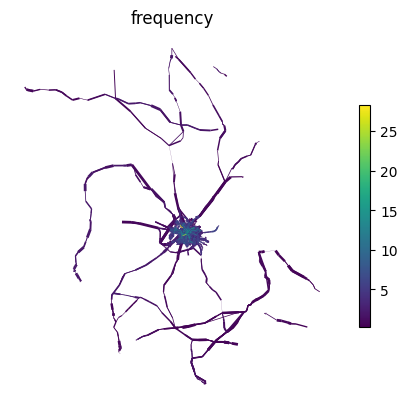

In [113]:
gx.utils.plot_network(nx_graph_ber, 'frequency')

## Preprocessing: Convert to torch graph

In [398]:
# Berlin route types

route_types = {
    100: 'train',
    109: 'train',
    400: 'rail',
    700: 'bus',
    900: 'tram',
    1000: None,
    2: None,
}

In [94]:
G = nx_graph.copy()
edges = utils.edges_to_gdf(G)
nodes = utils.nodes_to_gdf(G)

# Preprocess route types
# nodes['route_type'] = nodes['route_type'].map(route_types).astype('category')
nodes['route_type'] = nodes['route_type'].astype('category')
nodes = nodes.dropna(subset=['route_type'])

# Remove walk edges
edges = edges[edges['mode'] != 'walk']
edges = edges[edges['weight'] != 0]

# Add additional speed feature
edges['speed'] = edges.geometry.length / edges['weight']
nodes['speed'] = edges.reset_index().groupby('u')['speed'].mean()
nodes = nodes[nodes['speed'].notna()]

# Create edge index for torch graph
edges = edges[edges.index.get_level_values('u').isin(nodes.index) & edges.index.get_level_values('v').isin(nodes.index)]
mapping = dict(zip(nodes.index, range(len(nodes))))
edge_index = torch.empty((2, len(edges)), dtype=torch.long)
edge_weight = torch.tensor(edges['weight'].values, dtype=torch.float32)

for i, (src, dst) in enumerate(edges.index):
    edge_index[0, i] = mapping[src]
    edge_index[1, i] = mapping[dst]

# Create torch graph
y = torch.tensor(nodes['route_type'].cat.codes.values, dtype=torch.long)
x = torch.tensor(nodes[['frequency', 'speed']].values, dtype=torch.float32)
graph = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_weight)

In [ ]:
# Conversion using pytorch geometric helper function

G = nx_graph.copy()

# Remove walk edges
for n1, n2, d in nx_graph.edges(data=True):
    if d.get('mode') == 'walk':
        G.remove_edge(n1, n2)

# Convert categorical mode edges to numerical weight used in GNN message passing
# for n1, n2, d in G.copy().edges(data=True):
#     if d.get('mode') != 'walk':
#         # G[n1][n2]['mode'] = 'transit'
#         G[n1][n2]['mode'] = 1
#     else:
#         G[n1][n2]['mode'] = 0.1

G.graph = {}
graph = from_networkx(G, group_edge_attrs=['weight'], group_node_attrs=['service_frequency', 'headaway', 'centrality'])
graph.y = torch.from_numpy(nodes['route_type'].cat.codes.values)


## Model selection

In [61]:
class MLP(nn.Module):
    def __init__(self, n_fts, n_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_fts, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes)
        )

    def forward(self, data):
        x = data.x  # only using node features (x)
        output = self.layers(x)
        return output

In [60]:
class GCN(nn.Module):
    def __init__(self, n_fts, n_classes):
        super().__init__()
        self.conv1 = GCNConv(n_fts, 16)
        self.conv2 = GCNConv(16, n_classes)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr

        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        output = self.conv2(x, edge_index, edge_weight=edge_weight)

        return output

In [54]:
class GAT(nn.Module):
    def __init__(self, n_fts, n_classes):
        super().__init__()
        self.conv1 = GATConv(n_fts, 16, edge_dim=1)
        self.conv2 = GATConv(16, n_classes, edge_dim=1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        output = self.conv2(x, edge_index, edge_attr=edge_attr)

        return output

## Training & evaluation

In [75]:

def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):
    progress = []
    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, graph, graph.val_mask)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')
        
        progress.append((float(loss), acc))

    return model, progress


def eval_node_classifier(model, graph, mask):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())

    return acc

In [95]:
# test train validation split
split = T.RandomNodeSplit(num_val=0.2, num_test=0.2)
graph = split(graph)

In [96]:
# Hyperparameters

lr = 0.01
n_epochs = 200
weight_decay = 5e-4

route_type_counts = nodes['route_type'].value_counts().sort_index().values
weights = torch.tensor(1 / np.log(route_type_counts)).float()

n_classes = nodes['route_type'].nunique()
n_fts = graph.x.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch: 010, Train Loss: 0.923, Val Acc: 0.871
Epoch: 020, Train Loss: 0.755, Val Acc: 0.873
Epoch: 030, Train Loss: 0.606, Val Acc: 0.876
Epoch: 040, Train Loss: 0.564, Val Acc: 0.878
Epoch: 050, Train Loss: 0.542, Val Acc: 0.880
Epoch: 060, Train Loss: 0.538, Val Acc: 0.884
Epoch: 070, Train Loss: 0.536, Val Acc: 0.880
Epoch: 080, Train Loss: 0.534, Val Acc: 0.880
Epoch: 090, Train Loss: 0.534, Val Acc: 0.878
Epoch: 100, Train Loss: 0.532, Val Acc: 0.881
Epoch: 110, Train Loss: 0.531, Val Acc: 0.880
Epoch: 120, Train Loss: 0.529, Val Acc: 0.880
Epoch: 130, Train Loss: 0.529, Val Acc: 0.882
Epoch: 140, Train Loss: 0.528, Val Acc: 0.877
Epoch: 150, Train Loss: 0.526, Val Acc: 0.881
Epoch: 160, Train Loss: 0.525, Val Acc: 0.881
Epoch: 170, Train Loss: 0.526, Val Acc: 0.882
Epoch: 180, Train Loss: 0.525, Val Acc: 0.879
Epoch: 190, Train Loss: 0.524, Val Acc: 0.879
Epoch: 200, Train Loss: 0.523, Val Acc: 0.880
Test Acc: 0.864


<Axes: >

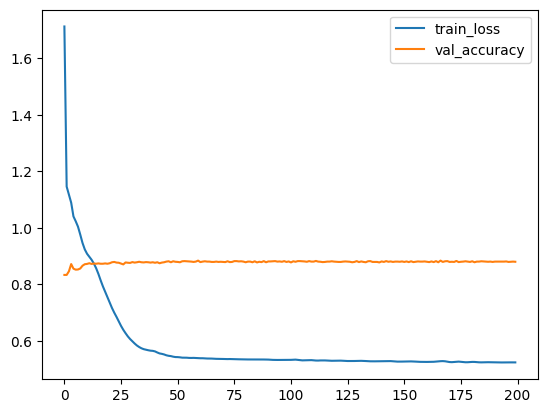

In [92]:
# MLP approach

mlp = MLP(n_fts, n_classes).to(device)
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(weight=weights)
mlp, progress = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs=n_epochs)

test_acc = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

pd.DataFrame(data=progress, columns=['train_loss', 'val_accuracy']).plot()


Epoch: 010, Train Loss: 1.496, Val Acc: 0.776
Epoch: 020, Train Loss: 1.166, Val Acc: 0.844
Epoch: 030, Train Loss: 1.028, Val Acc: 0.846
Epoch: 040, Train Loss: 0.938, Val Acc: 0.850
Epoch: 050, Train Loss: 0.881, Val Acc: 0.849
Epoch: 060, Train Loss: 0.840, Val Acc: 0.856
Epoch: 070, Train Loss: 0.804, Val Acc: 0.859
Epoch: 080, Train Loss: 0.773, Val Acc: 0.856
Epoch: 090, Train Loss: 0.746, Val Acc: 0.851
Epoch: 100, Train Loss: 0.724, Val Acc: 0.855
Epoch: 110, Train Loss: 0.707, Val Acc: 0.853
Epoch: 120, Train Loss: 0.694, Val Acc: 0.855
Epoch: 130, Train Loss: 0.684, Val Acc: 0.854
Epoch: 140, Train Loss: 0.675, Val Acc: 0.855
Epoch: 150, Train Loss: 0.668, Val Acc: 0.855
Epoch: 160, Train Loss: 0.662, Val Acc: 0.856
Epoch: 170, Train Loss: 0.657, Val Acc: 0.857
Epoch: 180, Train Loss: 0.652, Val Acc: 0.856
Epoch: 190, Train Loss: 0.648, Val Acc: 0.857
Epoch: 200, Train Loss: 0.644, Val Acc: 0.859
Test Acc: 0.862


<Axes: >

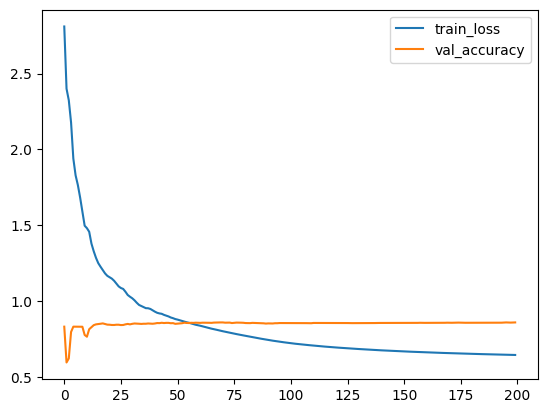

In [98]:
# GNN approach

gcn = GCN(n_fts, n_classes).to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(weight=weights)

gcn, progress = train_node_classifier(gcn, graph, optimizer_gcn, criterion, n_epochs=n_epochs)
test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

pd.DataFrame(data=progress, columns=['train_loss', 'val_accuracy']).plot()


Epoch: 010, Train Loss: 1.080, Val Acc: 0.826
Epoch: 020, Train Loss: 0.908, Val Acc: 0.853
Epoch: 030, Train Loss: 0.823, Val Acc: 0.851
Epoch: 040, Train Loss: 0.764, Val Acc: 0.855
Epoch: 050, Train Loss: 0.716, Val Acc: 0.855
Epoch: 060, Train Loss: 0.683, Val Acc: 0.856
Epoch: 070, Train Loss: 0.657, Val Acc: 0.857
Epoch: 080, Train Loss: 0.636, Val Acc: 0.858
Epoch: 090, Train Loss: 0.613, Val Acc: 0.858
Epoch: 100, Train Loss: 0.592, Val Acc: 0.859
Epoch: 110, Train Loss: 0.575, Val Acc: 0.859
Epoch: 120, Train Loss: 0.563, Val Acc: 0.860
Epoch: 130, Train Loss: 0.549, Val Acc: 0.860
Epoch: 140, Train Loss: 0.537, Val Acc: 0.862
Epoch: 150, Train Loss: 0.530, Val Acc: 0.860
Epoch: 160, Train Loss: 0.517, Val Acc: 0.863
Epoch: 170, Train Loss: 0.511, Val Acc: 0.862
Epoch: 180, Train Loss: 0.501, Val Acc: 0.862
Epoch: 190, Train Loss: 0.495, Val Acc: 0.863
Epoch: 200, Train Loss: 0.489, Val Acc: 0.865
Test Acc: 0.857


<Axes: >

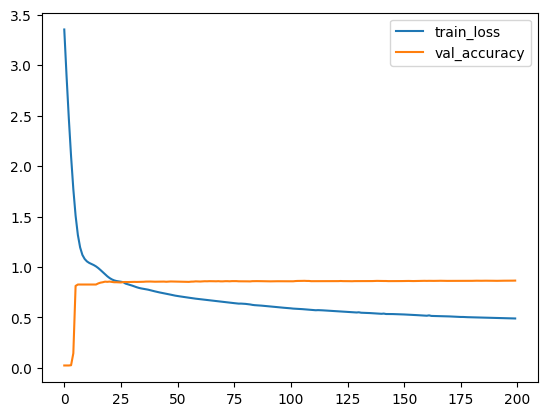

In [69]:
# GAT approach

gcn = GAT(n_fts, n_classes).to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(weight=weights)

gcn, progress = train_node_classifier(gcn, graph, optimizer_gcn, criterion, n_epochs=n_epochs)
test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

pd.DataFrame(data=progress, columns=['train_loss', 'val_accuracy']).plot()


In [427]:
pred = gcn(graph).argmax(dim=1)
nodes['pred'] = pred
nodes['true'] = nodes['route_type'].astype('category').cat.codes
nodes[nodes['pred'] != nodes['true']]['true'].value_counts()

true
4    366
2    291
0    200
3    148
1     67
Name: count, dtype: int64

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


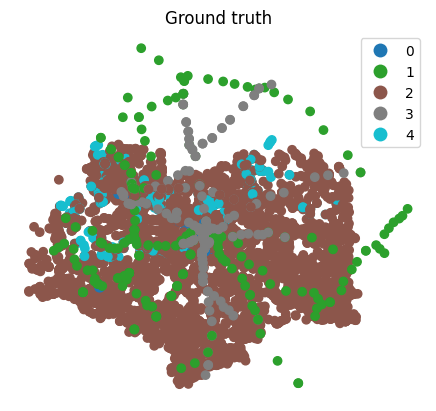

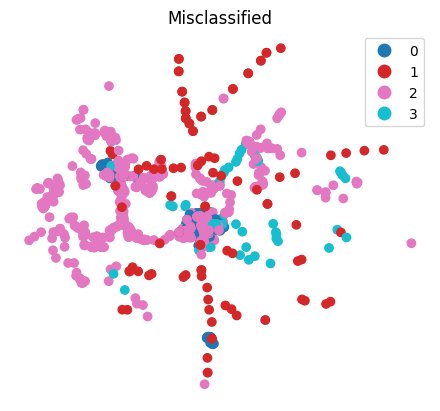

In [435]:
ax = nodes.plot(column='true', categorical=True, legend=True)
ax.set_title('Ground truth')
ax.set_axis_off()

ax = nodes[nodes['pred'] != nodes['true']].plot(column='pred', categorical=True, legend=True)
ax.set_title('Misclassified')
ax.set_axis_off()

# nodes[nodes['pred'] != nodes['true']].explore('route_type', categorical=True, legend=True)
# nodes[nodes['pred'] == nodes['true']].explore('route_type', categorical=True, legend=True)
